# パチンコ産業のモデル

パチンコ産業の199Xをピークに徐々に市場規模を縮小させてきた。その原因について推測が行われてきたが分析はすくない。本稿はパチンコ産業のモデル化を行い、隆盛と縮退の原因を可視化することを目的にする。パチンコ産業の隆盛を判断する指標として参加プレイヤーの推計人数を採用する。本産業で「隆盛」を語る際、もっぱら参加者の数が主題になる。多くに施策はユーザーの参加を促し離脱を防ぐために行われる。本稿でももっぱらプレイヤーを問題にし、消費金額については別に機会に譲るとする。

パチンコユーザーの定義

In [ ]:
using Distributions,StatsPlots, Turing
using DataFrames,CSV,LinearAlgebra,MCMCChains
#using Symbolics
using Optim, Latexify
#using ModelingToolkit

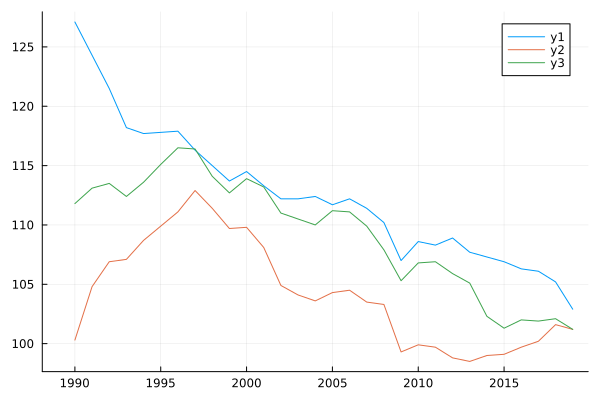

In [2]:
dx = CSV.read("p-datasets2.csv",DataFrame);
@df dx plot(:年,[:労働時間, :名目賃金, :実質賃金])

In [3]:
df = CSV.read("pachinko_jinko_eq.csv",DataFrame)

Row,年,総人口,パチンコ参加人口,eq
,Int64,Int64,Int64,Float64
1,1994,125265,29300,0.0
2,1995,125570,29000,0.0
3,1996,125859,27600,0.0
4,1997,126157,23100,0.0
5,1998,126472,19800,0.0
6,1999,126667,18600,0.0
7,2000,126926,20200,0.0
8,2001,126926,19300,0.0
9,2002,127316,21700,0.0


# モデルのアイディア
パチンコユーザーが測定期間（１年）の間にプレイヤーを継続する確率をaとし、ノンユーザーがパチンコプレイヤーになる確率をbとする。

In [4]:
#@variables P N a b 
#M=[ a 1-a ; b 1-b]
latexify("M=[ a 1-a ; b 1-b]")

L"$M = \left[
\begin{array}{cc}
a & 1 - a \\
b & 1 - b \\
\end{array}
\right]$"

In [5]:
latexify("A= [P,N]")

L"$A = \left[
\begin{array}{c}
P \\
N \\
\end{array}
\right]$"

In [6]:
latexify("Z = A' * M = [ P N ] * [ a 1-a ; b 1-b] = [Nb+Pa N(1-b)+P(1-a)]")

L"$Z = A' \cdot M = \left[
\begin{array}{cc}
P & N \\
\end{array}
\right] \cdot \left[
\begin{array}{cc}
a & 1 - a \\
b & 1 - b \\
\end{array}
\right] = \left[
\begin{array}{cc}
Nb + Pa & N\left( 1 - b \right) + P\left( 1 - a \right) \\
\end{array}
\right]$"

In [7]:
# Z[1,1] + Z[1,2] |> simplify 
latexify(" Σ(Z)  = Nb+Pa+N(1-b)+P(1-a) = N+P")

L"$\Sigma\left( Z \right) = Nb + Pa + N\left( 1 - b \right) + P\left( 1 - a \right) = N + P$"

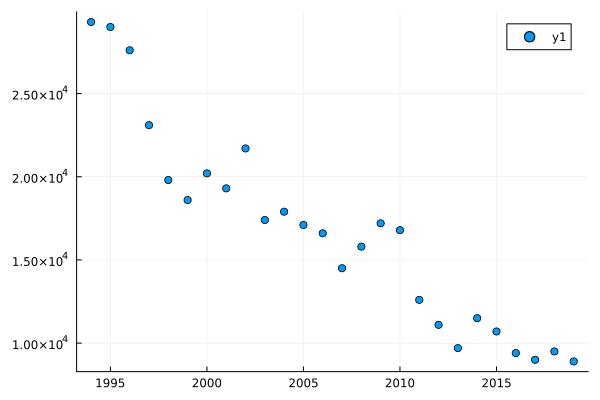

In [8]:
year = df[:,1] |> Vector
data = df[:,2:end] |> Matrix |> t-> t .* [1 1 1]
scatter(year, data[:,2])

In [9]:
data = hcat( data[:,2], data[:,1] .- data[:,2], data[:,3])

26×3 Matrix{Float64}:
 29300.0   95965.0  0.0
 29000.0   96570.0  0.0
 27600.0   98259.0  0.0
 23100.0  103057.0  0.0
 19800.0  106672.0  0.0
 18600.0  108067.0  0.0
 20200.0  106726.0  0.0
 19300.0  107626.0  0.0
 21700.0  105616.0  0.0
 17400.0  110086.0  0.0
     ⋮              
 12600.0  115457.0  1.0
 11100.0  116734.0  1.0
  9700.0  117893.0  1.0
 11500.0  115914.0  1.0
 10700.0  116537.0  1.0
  9400.0  117695.0  1.0
  9000.0  117933.0  1.0
  9500.0  117206.0  1.0
  8900.0  117543.0  1.0

In [10]:
@model function pachinko(data::Matrix ; m= size(data)[1], n=size(data)[2])
    a ~ Beta(2,3)
    b ~ Beta(2,3)
    w ~ MvNormal([0,0], 10*I)
    s ~ Exponential(1)
    M = [ a 1-a ; b 1-b]
    for i = 1:m-1
        Px = data[i,1:2]
        Pt = Px' * M .+ w'
        data[i+1,1] ~ Normal( Pt[1,1], s)
    end
    #return (; N=N, P=P, Px=Px)
end

pachinko (generic function with 2 methods)

In [11]:
year

26-element Vector{Int64}:
 1994
 1995
 1996
 1997
 1998
 1999
 2000
 2001
 2002
 2003
    ⋮
 2011
 2012
 2013
 2014
 2015
 2016
 2017
 2018
 2019

In [12]:
c1 = sample(pachinko(data),NUTS(),2000 ; progress=false)

┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\cplDJ\src\inference\hmc.jl:204


Chains MCMC chain (2000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 10.93 seconds
Compute duration  = 10.93 seconds
parameters        = a, b, w[1], w[2], s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

           a     0.8962    0.0111    0.0003   1209.1822   1169.4860    0.9996  ⋯
           b     0.0087    0.0018    0.0001   1167.8308   1126.7246    0.9999  ⋯
        w[1]     0.0263    3.2034    0.0813   1552.5515   1009.1034    1.0006  ⋯
        w[2]     0.0416    3.2434    0.0767   1857.8251   1431.1620    1.0002  ⋯
           s   411.5817   11.7919    0.2915   1636.0

In [13]:
quantile(c1)

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           a     0.8743     0.8887     0.8958     0.9041     0.9183
           b     0.0052     0.0075     0.0087     0.0099     0.0123
        w[1]    -6.0861    -2.1645    -0.1001     2.1427     6.7206
        w[2]    -6.2867    -2.1951     0.0550     2.2152     6.3527
           s   388.7254   403.8132   411.1966   419.6009   435.1428


In [14]:
function get_range(c1,i,; params=[:a,:b])
    eq = quantile(c1)[params,:][:,2:6]
    return (; zip(params, eq[:,i])...)
end
function predict_data( data, parameter )
    M = [parameter.a 1-parameter.a ; parameter.b 1-parameter.b]
    Ps = copy(data[:,1:2])
    w = [ parameter[Symbol("w[1]")], parameter[Symbol("w[2]")]]
    for i = 1:size(Ps)[1]-1
        Pt = data[i,1:2]' * M .+ w'
        Ps[i+1,:] = Pt'
    end
    return Ps
end

predict_data (generic function with 1 method)

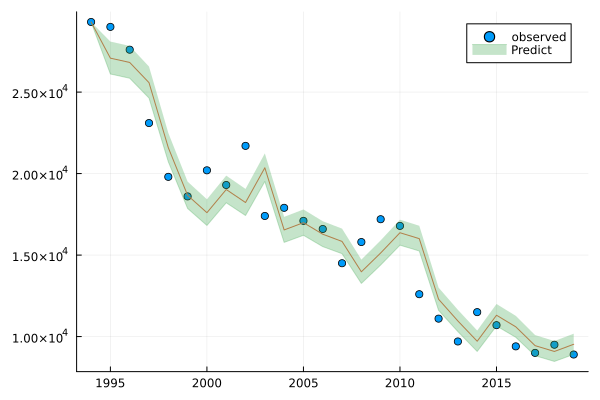

In [15]:
prams = [ get_range(c1,i ; params=[:a,:b,Symbol("w[1]"), Symbol("w[2]")] ) for i = [1,3,5]]
rs = hcat([predict_data(data, z)[:,1] for z in prams]...)
scatter(year, data[:,1],label="observed")
plot!(year, rs[:,2] , label="")
plot!(year, rs[:,1], fillrange=rs[:,3],alpha=0.3, label="Predict")

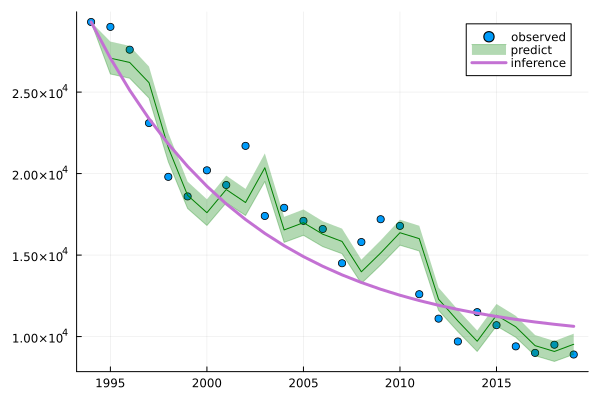

In [16]:
function inference_data(data,parameter::NamedTuple)
    M = [parameter.a 1-parameter.a ; parameter.b 1-parameter.b]
    Ps = copy(data[:,1:2])
    w = [ parameter[Symbol("w[1]")], parameter[Symbol("w[2]")]]
    for i = 2:size(Ps)[1]
        Pt = Ps[i-1,:]' * M .+ w'
        Ps[i,:] = Pt'
    end
    return Ps
end

ifr = inference_data(data, prams[2]) #mid
scatter(year, data[:,1],label="observed")
plot!(year, rs[:,2], c=:green , label="")
plot!(year, rs[:,1], fillrange=rs[:,3],alpha=0.3, c=:green , label="predict")
plot!(year,ifr[:,1], lw=3, label="inference")

In [17]:
data

26×3 Matrix{Float64}:
 29300.0   95965.0  0.0
 29000.0   96570.0  0.0
 27600.0   98259.0  0.0
 23100.0  103057.0  0.0
 19800.0  106672.0  0.0
 18600.0  108067.0  0.0
 20200.0  106726.0  0.0
 19300.0  107626.0  0.0
 21700.0  105616.0  0.0
 17400.0  110086.0  0.0
     ⋮              
 12600.0  115457.0  1.0
 11100.0  116734.0  1.0
  9700.0  117893.0  1.0
 11500.0  115914.0  1.0
 10700.0  116537.0  1.0
  9400.0  117695.0  1.0
  9000.0  117933.0  1.0
  9500.0  117206.0  1.0
  8900.0  117543.0  1.0

## 震災のような重要な出来事をモデルに組み込む

In [18]:
#@variables P N a b c d ϵ
#M=[ a 1-a ; b 1-b]
#E=[ c 1-c ; d 1-d] 
#Z = [P,N]' * M  * (E ^ 1)
latexify("[P N] * [ a 1-a ; b 1-b]  * [ c 1-c ; d 1-d]  ^ ϵ")


L"$\left[
\begin{array}{cc}
P & N \\
\end{array}
\right] \cdot \left[
\begin{array}{cc}
a & 1 - a \\
b & 1 - b \\
\end{array}
\right] \cdot \left[
\begin{array}{cc}
c & 1 - c \\
d & 1 - d \\
\end{array}
\right]^{\epsilon}$"

In [19]:
#Z[1,1] + Z[1,2] |> simplify

In [20]:
#[P,N]' * M  * (E ^ 0)

In [21]:
@model function pachinko_eq(data::Matrix ; m= size(data)[1], n=size(data)[2])
    a ~ Beta(2,3)
    b ~ Beta(2,3)
    c ~ Beta(2,3)
    d ~ Uniform(0, 1.0e-6)
    w ~ MvNormal([0,0], 10*I)
    s ~ Exponential(1)
    M = [ a 1-a ; b 1-b]
    E = [ c 1-c ; d 1-d]
    for i = 1:m-1
        Px = data[i,1:2]
        ϵ = Integer.(data[i+1,3])
        Pt = Px' * M * ( E ^ ϵ ) + w'
        data[i+1,1] ~ Normal( Pt[1,1], s)
    end
    #return (; N=N, P=P, Px=Px)
end

pachinko_eq (generic function with 2 methods)

In [22]:
#data[19:end,3] .= 0
data

26×3 Matrix{Float64}:
 29300.0   95965.0  0.0
 29000.0   96570.0  0.0
 27600.0   98259.0  0.0
 23100.0  103057.0  0.0
 19800.0  106672.0  0.0
 18600.0  108067.0  0.0
 20200.0  106726.0  0.0
 19300.0  107626.0  0.0
 21700.0  105616.0  0.0
 17400.0  110086.0  0.0
     ⋮              
 12600.0  115457.0  1.0
 11100.0  116734.0  1.0
  9700.0  117893.0  1.0
 11500.0  115914.0  1.0
 10700.0  116537.0  1.0
  9400.0  117695.0  1.0
  9000.0  117933.0  1.0
  9500.0  117206.0  1.0
  8900.0  117543.0  1.0

In [23]:
#ctest = sample(pachinko_test(data),NUTS(), 2000 ; progress=false)

In [24]:
c2 = sample(pachinko_eq(data),NUTS(), 2000 ; progress=false)

┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\cplDJ\src\inference\hmc.jl:204


Chains MCMC chain (2000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 12.64 seconds
Compute duration  = 12.64 seconds
parameters        = a, b, c, d, w[1], w[2], s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

           a     0.7867    0.0157    0.0005    884.1826    859.0002    0.9996  ⋯
           b     0.0335    0.0030    0.0001    833.6179    892.1370    0.9995  ⋯
           c     0.8049    0.0151    0.0005   1078.1059   1144.7651    0.9996  ⋯
           d     0.0000    0.0000    0.0000   1900.9545   1133.5461    1.0019  ⋯
        w[1]     0.0999    3.2334    0.0739   

In [25]:
quantile(c2)

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           a     0.7566     0.7764     0.7868     0.7974     0.8175
           b     0.0278     0.0315     0.0335     0.0356     0.0393
           c     0.7759     0.7949     0.8047     0.8149     0.8347
           d     0.0000     0.0000     0.0000     0.0000     0.0000
        w[1]    -6.2141    -2.1045     0.0226     2.2870     6.4959
        w[2]    -6.5538    -2.1399     0.1206     2.2420     6.0931
           s   351.3421   364.8716   372.4976   379.7113   394.5203


In [26]:
function predict_eq( data, prm )
    M = [prm.a 1-prm.a ; prm.b 1-prm.b]
    E = [prm.c 1-prm.c ; prm.d 1-prm.d]
    ϵ = data[:,3]
    Ps = copy(data[:,1:2])
    w = [ prm[Symbol("w[1]")],prm[Symbol("w[2]")]]
    for i = 1:size(Ps)[1]-1
        Pt = data[i,1:2]' * M * ( E ^ ϵ[i+1]) + w'
        #Ps[i+1,:] = [Pt[1,1] sum(data[i+1,:])-Pt[1,1]]
        Ps[i+1,:] = Pt'
    end
    return  Ps
end

predict_eq (generic function with 1 method)

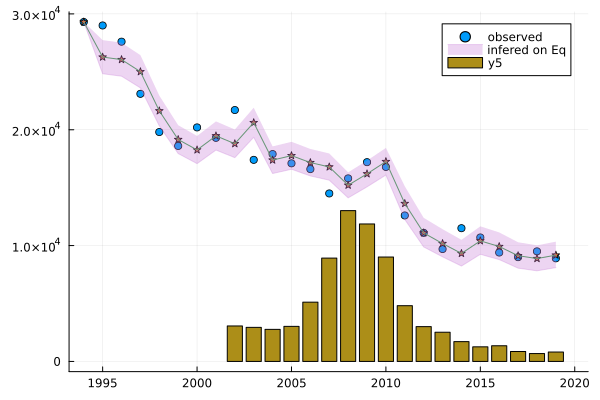

In [27]:
prams = [ get_range(c2,i ; params=[:a,:b,:c,:d,Symbol("w[1]"), Symbol("w[2]")]) for i = [1,3,5]]
rs_eq = hcat([predict_eq(data, z)[:,1] for z in prams]...)
pl_eq = scatter(year, data[:,1],label="observed")
pl_eq = scatter!(year, rs_eq[:,2],label="",m=:star)
pl_eq = plot!(year, rs_eq[:,2],label="")
pl_eq = plot!(year, rs_eq[:,1], fillrange=rs_eq[:,3],alpha=0.3, label="infered on Eq")
#plot!(year, rs[:,1], fillrange=rs[:,3],alpha=0.3,label="without Eq")
plot(pl_eq)
bar!(dx[14:end,:年],dx[14:end,:東京GRP] ./10)

In [28]:
prams = [ get_range(c2,i ; params=[:a,:b,:c,:d,Symbol("w[1]"), Symbol("w[2]")]) for i = [1,3,5]]
rs=predict_eq(data, prams[2])
sum(rs, dims=2) .- sum(data, dims=2)

26×1 Matrix{Float64}:
    0.0
 -304.8567415121652
 -288.8567415121652
 -297.8567415121652
 -314.8567415121652
 -194.85674151216517
 -258.8567415121652
    0.14325848783482797
 -389.8567415121652
 -169.85674151216517
    ⋮
  -25.856741512165172
  222.14325848783483
  240.14325848782028
  178.14325848782028
  176.14325848783483
  141.14325848783483
  161.14325848782028
  226.14325848783483
  262.1432584878203

In [29]:
quantile(c2) |> DataFrame

Row,parameters,2.5%,25.0%,50.0%,75.0%,97.5%
,Symbol,Float64,Float64,Float64,Float64,Float64
1,a,0.75663,0.776379,0.786784,0.797364,0.817504
2,b,0.0278083,0.0315003,0.0335239,0.0356248,0.0393436
3,c,0.775884,0.794926,0.804672,0.814905,0.834744
4,d,2.94279e-8,2.47897e-7,5.00723e-7,7.61982e-7,9.72194e-7
5,w[1],-6.21412,-2.10455,0.0226434,2.28702,6.4959
6,w[2],-6.55383,-2.13987,0.120615,2.24198,6.09309
7,s,351.342,364.872,372.498,379.711,394.52


In [30]:
prams

3-element Vector{NamedTuple{(:a, :b, :c, :d, Symbol("w[1]"), Symbol("w[2]")), NTuple{6, Float64}}}:
 (a = 0.7566298748656828, b = 0.02780828156361331, c = 0.7758835521199062, d = 2.9427949932874953e-8, var"w[1]" = -6.214116735810027, var"w[2]" = -6.553827816875983)
 (a = 0.7867836443754435, b = 0.03352391701994741, c = 0.8046720684305835, d = 5.007231549330629e-7, var"w[1]" = 0.022643401381445993, var"w[2]" = 0.12061508644457505)
 (a = 0.8175039923632658, b = 0.039343581419464965, c = 0.8347438559995007, d = 9.721942165281549e-7, var"w[1]" = 6.4959020613224885, var"w[2]" = 6.093089653777446)

In [31]:
M = [prams[2].a 1-prams[2].a ; prams[2].b 1-prams[2].b]


2×2 Matrix{Float64}:
 0.786784   0.213216
 0.0335239  0.966476

In [32]:
E = [prams[2].c 1-prams[2].c ; prams[2].d 1-prams[2].d]

2×2 Matrix{Float64}:
 0.804672    0.195328
 5.00723e-7  0.999999

## 複数のイベントを検出する

In [33]:
mdata = data[:,1:2]
edata_1 = data[:,3]
edata_2 = zeros(Float64, 26) ; edata_2[1:5] .= 1
edata_3 = zeros(Float64, 26) ; edata_3[5:11] .= 1

7-element view(::Vector{Float64}, 5:11) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [34]:
edata=hcat(edata_1)

26×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [12]:
@model function pachinko_multievent(mdata::Matrix, edata::Array )
    m= size(mdata)[1]
    if isa(edata, Vector)
        n = 1
    else
        n = size(edata)[2]
    end

    u ~ filldist(Beta(2,3),2) 
    Mu = [ u[1] 1-u[1] ;
           u[2] 1-u[2] ]
    
    e ~ filldist(Beta(2,3),n)  
    v ~ filldist(Uniform(0, 1.0e-6),n)   
    Ev = [[e[i] 1-e[i] ;
           v[i] 1-v[i] ] for i = 1:n] 
    w ~ MvNormal([0,0], 10*I)
    s ~ Exponential(1)
    for i = 2:m
        Px = mdata[i-1,1:2]
        ve = edata[i,:]
        V  = reduce(*, [E ^ e for (E,e) in zip(Ev, ve)] )
        Pt = Px' * Mu * V + w'
        mdata[i,1] ~ Normal( Pt[1,1], s)
    end
    #return (; N=N, P=P, Px=Px)
end

pachinko_multievent (generic function with 2 methods)

In [36]:
m = pachinko_multievent(mdata,edata)
cm = sample(m,NUTS(),2000 ; progress=false)

┌ Info: Found initial step size
│   ϵ = 1.52587890625e-6
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\cplDJ\src\inference\hmc.jl:204


Chains MCMC chain (2000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 17.4 seconds
Compute duration  = 17.4 seconds
parameters        = u[1], u[2], e[1], v[1], w[1], w[2], s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

        u[1]     0.7868    0.0151    0.0005    839.6046   1067.2477    1.0032  ⋯
        u[2]     0.0336    0.0029    0.0001    781.4471    975.5487    1.0026  ⋯
        e[1]     0.8050    0.0150    0.0005    986.4946   1080.7019    1.0026  ⋯
        v[1]     0.0000    0.0000    0.0000   1980.5356   1134.9766    1.0006  ⋯
        w[1]     0.0818    3.0423   

In [37]:
quantile(cm)

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

        u[1]     0.7574     0.7764     0.7868     0.7971     0.8168
        u[2]     0.0281     0.0315     0.0336     0.0356     0.0393
        e[1]     0.7761     0.7949     0.8048     0.8150     0.8337
        v[1]     0.0000     0.0000     0.0000     0.0000     0.0000
        w[1]    -5.8069    -1.9389     0.0926     2.0773     5.9731
        w[2]    -6.1626    -2.2095    -0.0742     2.0010     6.0615
           s   352.2484   364.6743   371.9868   379.1363   394.0386


In [38]:
function pred_multi(cm,mdata,edata,lev)
    prams = quantile(cm)[:,lev]
    n = size(edata)[2]
    u = prams[1:2] ; e = prams[3:2+n] ;v = prams[n+2+1:2+2*n] ;w = prams[end-2:end-1]
    Mu = [ u[1] 1-u[1] ; u[2] 1-u[2]]
    Ev = [[e[i] 1-e[i] ; v[i] 1-v[i]] for i = 1:n]
    rdata = copy( mdata )
    for i = 1:size(rdata)[1]-1
        Px = mdata[i,1:2]
        ve = edata[i+1,:]
        V  = reduce(*, [E ^ v for (E,v) in zip(Ev, ve)] )
        Pt = Px' * Mu * V + w'
        rdata[i+1,:] = Pt' #[ Pt[1,1]  sum(mdata[i+1,:]) - Pt[1,1] ]
    end
    return Ev, rdata
end

pred_multi (generic function with 1 method)

In [39]:
_, rs_mid = pred_multi(cm,mdata,edata,4)
ev, rs_high = pred_multi(cm,mdata,edata,6)
_, rs_low = pred_multi(cm,mdata,edata,2)

([[0.7761192591445236 0.22388074085547638; 2.7399568290289406e-8 0.9999999726004317]], [29300.0 95965.0; 24880.710289244882 100372.32018643178; … ; 7855.867682507307 119065.16279316935; 8133.913143137553 118560.1173325391])

In [40]:
ev[2]

BoundsError: BoundsError: attempt to access 1-element Vector{Matrix{Float64}} at index [2]

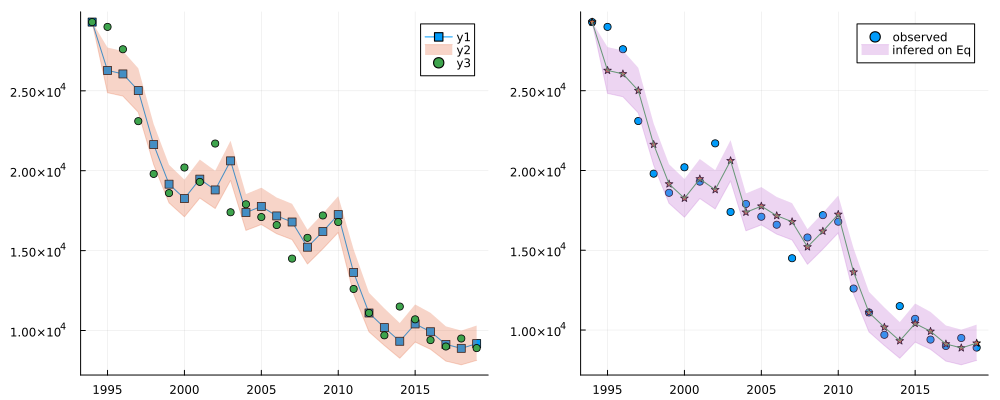

In [41]:
pl_x = plot(year, rs_mid[:,1],shape=:rect)
pl_x = plot!(year, rs_low[:,1], fillrange=rs_high[:,1],alpha=0.3)
pl_x = scatter!(year, mdata[:,1])
plot(pl_x, pl_eq, size=(1000,400))
#bar!(dx[14:end,:年],dx[14:end,:東京GRP] ./10)

In [42]:
E

2×2 Matrix{Float64}:
 0.804672    0.195328
 5.00723e-7  0.999999

In [13]:
@model function pachinko_eventind(mdata::Matrix  )
    m= size(mdata)[1]
    
    #u ~ filldist(Beta(2,3),2) 
    u = zeros(Float64,2)
    #u[1] ~ truncated(Normal(0,3), 0.5, 0.9)
    #u[2] ~ truncated(Normal(0,3), 0.1, 0.5)
    u ~ filldist(Beta(3,2),2)
    Mu = [ u[1] 1-u[1] ;
           u[2] 1-u[2] ]
    
    e ~ Beta(2,3)  
    v ~ Uniform(0, 1.0e-6)
    Ev = [e 1-e ;
          v 1-v ]

    z = tzeros(m)
    #z ~ filldist(Bernoulli(0.5),m)
    for i = 1:m
        z[i] ~ Bernoulli(0.5)
    end
      
    w ~ MvNormal([0,0], 10*I)
    s ~ Exponential(1)
    for i = 2:m
        Px = mdata[i-1,1:2]
        V = Ev ^ z[i]
        Pt = Px' * Mu * V + w'
        mdata[i,1] ~ Normal( Pt[1,1], s)
    end
end



pachinko_eventind (generic function with 2 methods)

In [110]:
m2=pachinko_eventind(mdata)
cm2 = sample(m2, Gibbs(PG(25,:z),NUTS(1000, 0.65 , :u, :e, :v, :w, :s) ), MCMCThreads(), 2000, 4; progress=false)

┌ Info: Found initial step size
│   ϵ = 1.220703125e-5
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\cplDJ\src\inference\hmc.jl:204


Chains MCMC chain (2000×34×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1629.66 seconds
Compute duration  = 1629.66 seconds
parameters        = u[1], u[2], e, v, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], z[24], z[25], z[26], w[1], w[2], s
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        u[1]    0.6203    0.1889    0.0930     4.4524    15.3314    2.1237     ⋯
        u[2]    0.0662    0.0367    0.0179     4.4568    16.3745    2.1236     ⋯
           e    0.5181    0.2937    0.1435     4.4739    15.0039    2.1233     ⋯
           v    0.0000    0.0000    0.0000     5.6911    20.4661    1.7063     ⋯
        z[1]    0.1445    0.3517    0.1379     

In [105]:
quantile(cm2)

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        u[1]    0.4016    0.4434    0.4526    0.4569    0.4905
        u[2]    0.1556    0.3003    0.3467    0.3700    0.5748
           e    0.6260    0.6498    0.6559    0.6589    0.6879
           v    0.0000    0.0000    0.0000    0.0000    0.0000
        z[1]    0.0000    0.0000    0.0000    0.0000    1.0000
        z[2]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[3]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[4]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[5]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[6]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[7]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[8]    0.0000    0.0000    0.0000    0.0000    0.0000
        z[9]    0.0000    0.0000    0.0000    0.0000    0.0000
       z[10]    1.0000    1.0000    1.0000

In [187]:
prams = quantile(cm2)[:,4]
u = prams[1:2] ; e = prams[3] ;v = prams[4] ; z = prams[5:5+25] ; w = prams[end-2:end-1]
Mu = [ u[1] 1-u[1] ; u[2] 1-u[2]]
Ev = [ e 1-e ; 
       v 1-v ]        
rdata = copy( mdata )
for i = 1:size(rdata)[1]-1
    Px = mdata[i,1:2]
    V  = E ^ z[i+1] 
    Pt = Px' * Mu * V + w'
    rdata[i+1,:] = Pt' #[ Pt[1,1]  sum(mdata[i+1,:]) - Pt[1,1] ]
end

rdata

26×2 Matrix{Float64}:
 29300.0   95965.0
 24946.2       1.00322e5
 24784.1       1.00789e5
 23960.9       1.01902e5
 21277.8       1.04883e5
 19315.8       1.0716e5
 18607.1       1.08063e5
 19582.5       1.07347e5
 19042.4  107887.0
 16501.1       1.10818e5
     ⋮    
 14163.8       1.13872e5
 12141.5       1.15919e5
 11406.6       1.16431e5
 13320.2       1.14276e5
 14390.0       1.13027e5
 11185.2       1.16055e5
 10550.7       1.16548e5
 12861.3       1.14075e5
 13148.1       1.13561e5

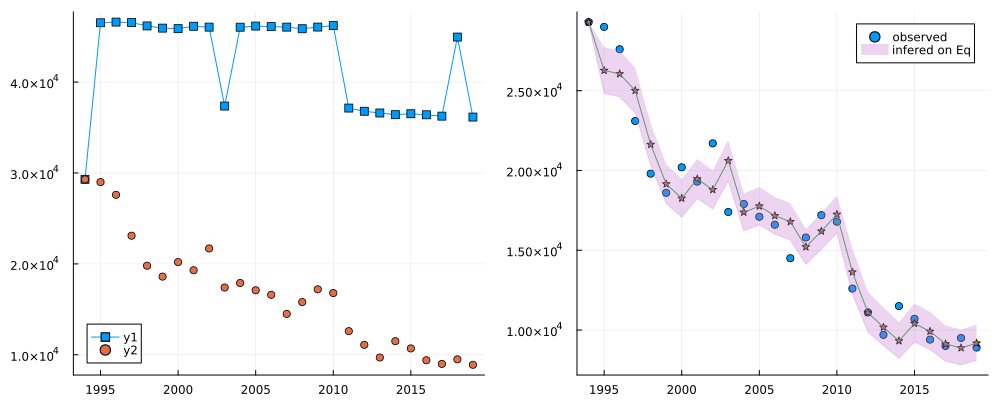

In [108]:
pl_z = plot(year, rdata[:,1],shape=:rect)
#pl_x = plot!(year, rs_low[:,1], fillrange=rs_high[:,1],alpha=0.3)
pl_z = scatter!(year, mdata[:,1])
plot(pl_z, pl_eq, size=(1000,400))

## テスト

In [14]:
begin 
    p0=30_000 ; n0 = 90_000

    Ms = [0.8 1-0.8 ; 0.03 1-0.03]
    Es = [0.7 1-0.7 ; 0 1 ]

    m = 30
    Rs = zeros(Float64,30,2) ; Rs[1,:] = [p0 n0]

    vs = [rand(Bernoulli(0.2)) for i = 1:m]
    #v = zeros(30) ; 
    vs[22:30] .= 1

    for i = 2:m
        Ps = Rs[i-1,:]' * Ms * ( Es ^ vs[i])
        Rs[i,:] = Ps
    end

end

In [15]:
size(Rs)[1]

30

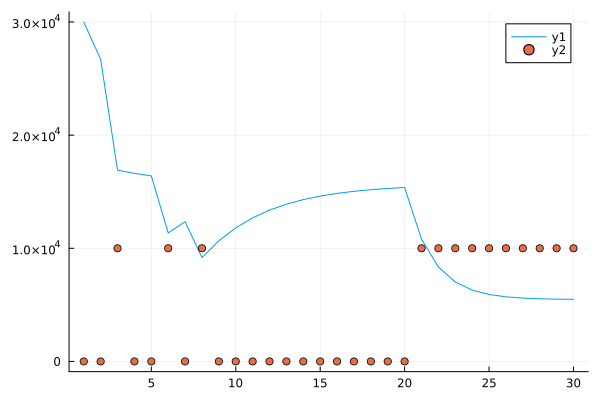

In [16]:
plot(Rs[:,1])
scatter!(vs .* 1e4)

In [43]:
mt=pachinko_eventind(Rs)
ct = sample(mt, Gibbs(PG(25,:z), NUTS(600, 0.65 , :u, :e, :v, :w, :s) ), 2000 ; progress=false)

┌ Info: Found initial step size
│   ϵ = 7.62939453125e-7
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\cplDJ\src\inference\hmc.jl:204


Chains MCMC chain (2000×38×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 210.08 seconds
Compute duration  = 210.08 seconds
parameters        = u[1], u[2], e, v, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], z[24], z[25], z[26], z[27], z[28], z[29], z[30], w[1], w[2], s
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        u[1]    0.5786    0.0214    0.0097     4.4473    15.0037    2.1238     ⋯
        u[2]    0.1340    0.0964    0.0381     4.4516    15.0037    2.1238     ⋯
           e    0.3865    0.0314    0.0147     4.4477    15.0037    2.1238     ⋯
           v    0.0000    0.0000    0.0000     8.3981    49.6141    1.2780     ⋯
        z[1]    0.440

In [25]:
quantile

quantile (generic function with 79 methods)

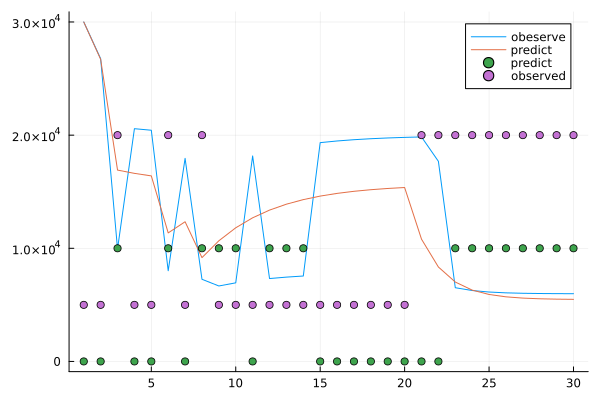

In [44]:
prams = quantile(ct)[:,4]
u = prams[1:2] ; e = prams[3] ;v = prams[4] ; z = prams[5:4+m] ; w = prams[end-2:end-1]
Mu = [ u[1] 1-u[1] ; u[2] 1-u[2]]
Ev = [ e 1-e ; 
       v 1-v ]        
    
rdata = copy( Rs )
for i = 2:m
    Px = Rs[i-1,1:2]
    V  = Ev ^ z[i] 
    Pt = Px' * Mu * V + w'
    rdata[i,:] = Pt' #[ Pt[1,1]  sum(mdata[i+1,:]) - Pt[1,1] ]
end
plot(rdata[:,1],label="obeserve")
plot!(Rs[:,1],label="predict")
scatter!(z .* 1e4, label="predict")
scatter!(vs .* 1.5e4 .+ 0.5e4, label="observed")

In [202]:
z

30-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0

## 人口データの更新を行わず初期値からモデル値を計算してみる

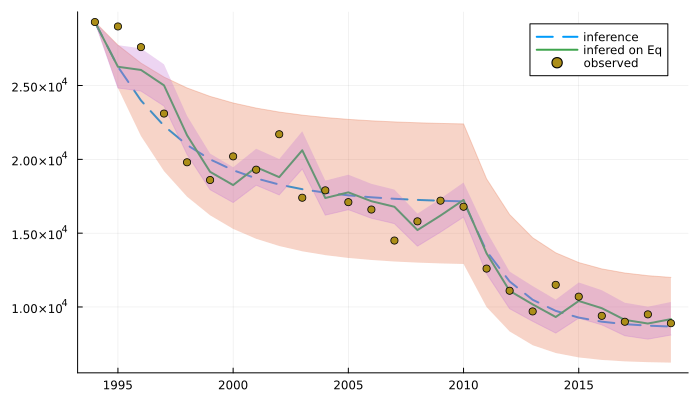

In [49]:
function inference_eq(data,parameter::NamedTuple)
    M = [parameter.a 1-parameter.a ; parameter.b 1-parameter.b]
    E = [parameter.c 1-parameter.c ; parameter.d 1-parameter.d]
    PNdata = data[:,1:2]
    ϵ = data[:,3] 
    Ps = copy(PNdata)
    w = [ parameter[Symbol("w[1]")], parameter[Symbol("w[2]")]]
    for i = 2:size(Ps)[1]
        Pt = Ps[i-1,:]' * M * ( E ^ ϵ[i]) + w'
        Ps[i,:] = Pt'
    end
    return Ps
end
ifr_eq = inference_eq(data, prams[2])
ifr_eq_low = inference_eq(data, prams[1])
ifr_eq_high = inference_eq(data, prams[3])

plot(year,ifr_eq[:,1], lw=2, label="inference",ls=:dash,size=(700,400))
plot!(year,ifr_eq_high[:,1], fillrange=ifr_eq_low[:,1], alpha=0.3, label="")

plot!(year, rs_eq[:,2],label="infered on Eq",lw=2)
plot!(year, rs_eq[:,1], fillrange=rs_eq[:,3],alpha=0.3, label="")
scatter!(year, data[:,1],label="observed")


In [50]:
function get_transitmatrix(parm,i)
    a = parm[i].a ;  b = parm[i].b
    c = parm[i].c ;  d = parm[i].d
    return [a 1-a ; b 1-b], [c 1-c; d 1-d]
end

function simulation(M, P0, N0 ; step=20)
    Ps = [P0 N0]
    for i = 1:step
        Pt = Ps[end,:]' * M
        Ps = vcat(Ps, Pt)
    end; return Ps
end

function simulation(Ms::Tuple, P0, As::Vector ; step=20)
    Ps = [P0 As[1]-P0]
    for i = 1:length(As)-1
        Pt = foldl( * , Ms ; init = Ps[end,:]') 
        #Pt = Ps[end,:]' * M
        #@show Pt
        Px = [Pt[1] As[i+1]-Pt[1]]
        Ps = vcat(Ps, Px)
    end; return Ps
end

simulation (generic function with 2 methods)

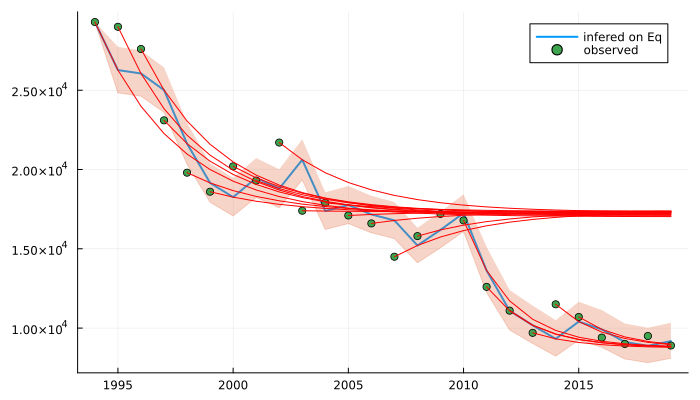

In [51]:
M, E = get_transitmatrix(prams,2) 
zs = Array{Union{Missing,Float64}}(missing, length(year), 22)
for i = 1:size(zs)[2]
    if i <= 16
        qs = simulation( M , data[i,1], data[i,2] ; step=length(year)-i)
    else
        qs = simulation( M*E , data[i,1], data[i,2] ; step=length(year)-i)
        #@show qs[:,1]
    end
    zs[i:end,i] = qs[:,1]
end

plot(year, rs_eq[:,2],label="infered on Eq",lw=2,size=(700,400))
plot!(year, rs_eq[:,1], fillrange=rs_eq[:,3],alpha=0.3, label="")
scatter!(year, data[:,1],label="observed")
plot!(year, zs, label="", c=:red)

In [52]:
M

2×2 Matrix{Float64}:
 0.786784   0.213216
 0.0335239  0.966476

In [ ]:
E

## 将来の予測を行う

In [ ]:
ndata = DataFrame(
    :year=>collect(2020:2030), 
    :people=>[126_146, 125_527, 124_978, 124_408, 123_844, 123_262, 122_661, 122_044, 121_414, 120_771, 120_116 ] )
    # :hall => repeat([missing],11) ) #:hall=>[9035,8458,7665,repeat(0,8)...]) 

In [ ]:
wprams = [ get_range(c2,i ; params=[:a,:b,:c,:d, Symbol("w[1]"), Symbol("w[2]")] ) for i = [1,2,3,4,5]];

In [ ]:
wide_pram = [get_transitmatrix(wprams,i) for i = 1:5]
sim_wide = [simulation( wide_pram[i], data[end,1], ndata[:,2])[:,1] for i = 1:5]

In [ ]:
plot(year,ifr_eq[:,1], lw=2, label="inference",ls=:dash,size=(700,400))
plot!(year,ifr_eq_high[:,1], fillrange=ifr_eq_low[:,1], alpha=0.3, label="")

plot!(year, rs_eq[:,2],label="infered on Eq",lw=2)
plot!(year, rs_eq[:,1], fillrange=rs_eq[:,3],alpha=0.3, label="")
scatter!(year, data[:,1],label="observed")

plot!(ndata[:,1], sim_wide[3], lw=3,ls=:dash, label="")
plot!(ndata[:,1], sim_wide[1], fillrange=sim_wide[5],alpha=0.3, label="predict future 95%")
plot!(ndata[:,1], sim_wide[2], fillrange=sim_wide[4],alpha=0.3, label="predict future 50%")

In [ ]:
DataFrame( :"year" => ndata[:,1], :"0.05%" => sim_wide[1], :"0.25%" => sim_wide[2], 
:"0.5%" => sim_wide[3], :"0.75%"=> sim_wide[4], :"0.95%" => sim_wide[5])